In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
df_orders = pd.read_csv('orders.csv')
df_payments = pd.read_csv('payments.csv')
df_plan = pd.read_csv('plan.csv')

# Установка отображения всех столбцов
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [15]:
# Изменяем тип данных с object на datetime
df_plan['plan_at'] = pd.to_datetime(df_plan['plan_at'])
df_payments['paid_at'] = pd.to_datetime(df_payments['paid_at'])
df_orders['created_at'] = pd.to_datetime(df_orders['created_at'])
df_orders['put_at'] = pd.to_datetime(df_orders['put_at'])
df_orders['closed_at'] = pd.to_datetime(df_orders['closed_at'])

In [16]:
# Присоединяем таблицу orders и таблицу payments по столбцу order_id
df_plan_full = df_orders.merge(df_plan, on='order_id', how='left')
df_full = df_plan_full.merge(df_payments, on='order_id', how='left')

In [17]:
# Считаем разницу в днях между датой факт.платежей и плановых платежей
df_full['days_diff'] = (df_full['paid_at'] - df_full['plan_at']).dt.days

# Добавляем флаг который указывает просрочен платеж или нет
df_full['overdue'] = df_full['days_diff'] > 0

In [18]:
# Сортируем и удаляем дубликаты
df_full = df_full.sort_values(by=['order_id', 'plan_at', 'days_diff'])
df_full = df_full.drop_duplicates(subset=['order_id', 'plan_at'], keep='first')

In [19]:
# Среднее количество дней просрочки
df_overdue = df_full[df_full['overdue'] == True]
avg_overdue_days = df_overdue['days_diff'].mean()
print(f"Среднее количество дней просрочки: {avg_overdue_days:.2f} дней")

Среднее количество дней просрочки: 24.91 дней


In [20]:
# Доля просроченных платежей
overdue_percentage = len(df_overdue) / len(df_full) * 100
print(f"Доля всех просроченных платежей: {overdue_percentage:.2f}%")

Доля всех просроченных платежей: 4.42%


In [21]:
# Вынимаем месяц из даты планового платежа для группировки
df_full['payment_month'] = df_full['plan_at'].dt.to_period('M')

# Считаем сумму просроченных платежей и их общее кол-во
monthly = (df_full.groupby('payment_month')['overdue'].agg(['sum', 'count']))

# Считаем долю просрочек от общего количества по месяцам
monthly['overdue_rate'] = ((monthly['sum'] / monthly['count'] * 100).round(2))
print(monthly)

                sum  count  overdue_rate
payment_month                           
2022-06        2812  17980         15.64
2022-07        5443  44342         12.28
2022-08        6176  66450          9.29
2022-09        3059  65135          4.70
2022-10         863  62951          1.37
2022-11         227  60739          0.37
2022-12           7  55168          0.01
2023-01           0  34370          0.00
2023-02           0  12679          0.00
2023-03           0    458          0.00
2023-04           0      4          0.00
2023-05           0      4          0.00
2023-06           0      2          0.00


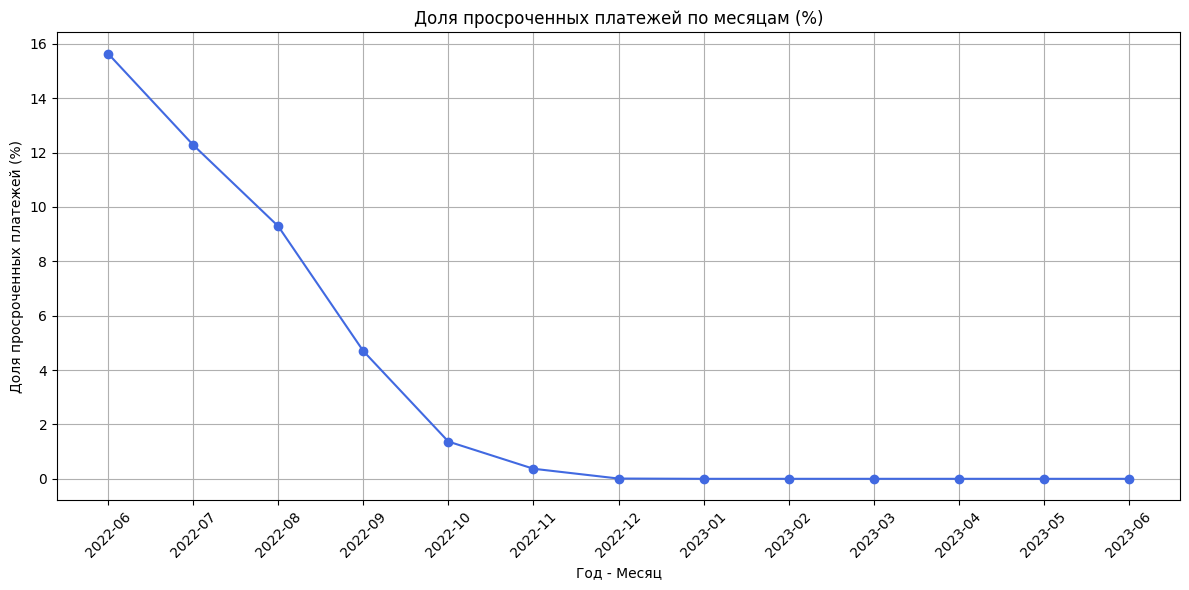

In [22]:
# График доли просроченных платежей по месяцам
plt.figure(figsize=(12, 6))
plt.plot(monthly.index.astype(str), monthly['overdue_rate'], marker='o', color='royalblue')
plt.title('Доля просроченных платежей по месяцам (%)')
plt.xlabel('Год - Месяц')
plt.ylabel('Доля просроченных платежей (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

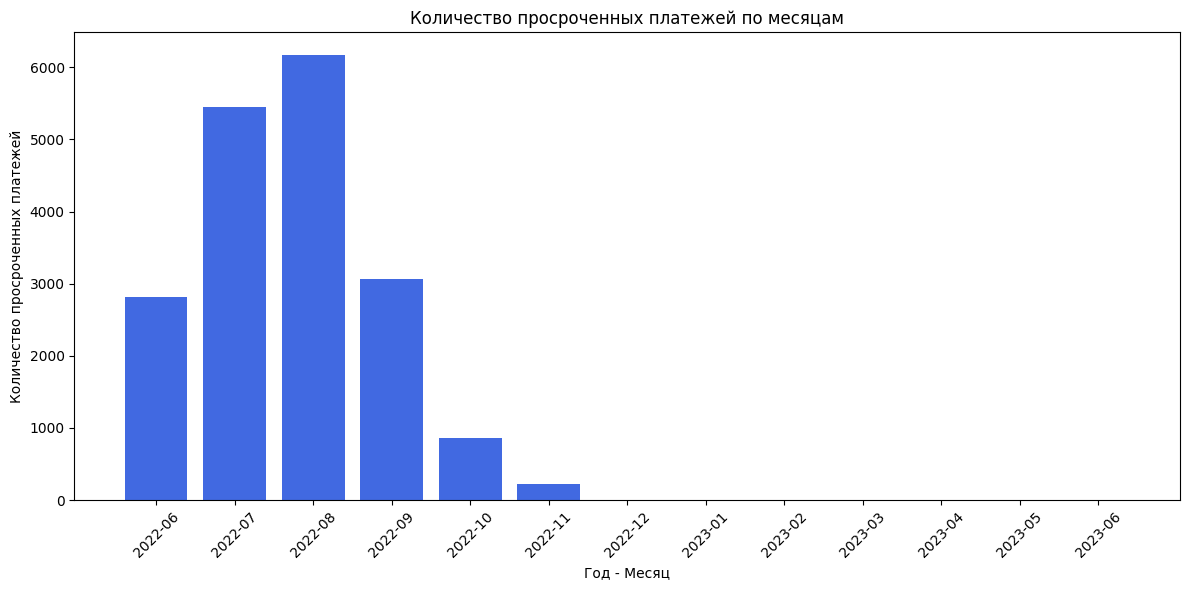

In [23]:
# График количества просроченных платежей по месяцам
plt.figure(figsize=(12, 6))
plt.bar(monthly.index.astype(str), monthly['sum'], color='royalblue')
plt.title('Количество просроченных платежей по месяцам')
plt.xlabel('Год - Месяц')
plt.ylabel('Количество просроченных платежей')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

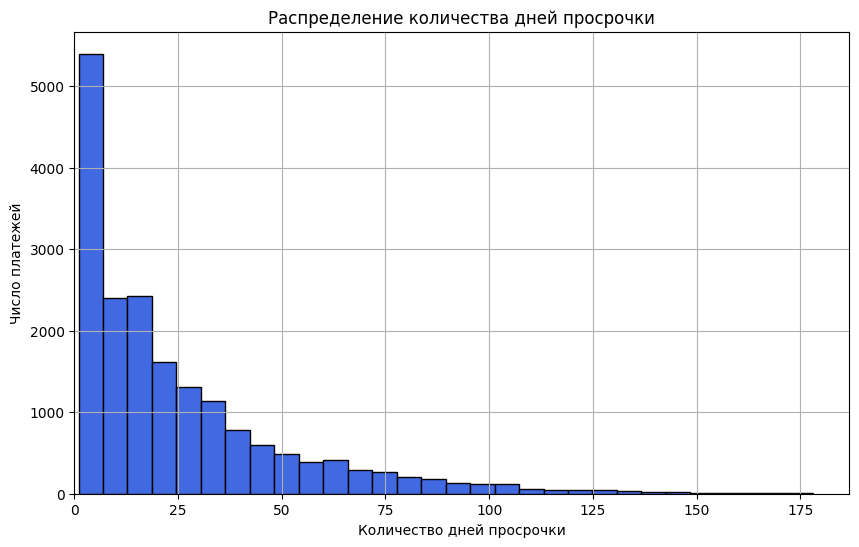

In [24]:
# Гистаграмма аспределения количества дней просрочки
plt.figure(figsize=(10, 6))
plt.hist(df_overdue['days_diff'], bins=30, color='royalblue', edgecolor='black')
plt.title('Распределение количества дней просрочки')
plt.xlabel('Количество дней просрочки')
plt.ylabel('Число платежей')
plt.grid(True)
plt.xlim(left=0)
plt.show()